In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
dv = np.load("data/cl_kkgal_input.npy")
ells = np.arange(len(dv))
zz, nz = np.load("data/dndz_input_z3_lensing_field_lsstlike.npy")

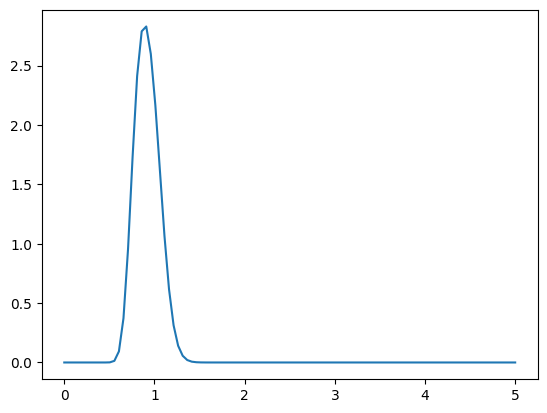

In [21]:
plt.plot(zz, nz)

In [19]:
from classy import Class
lmax = len(dv) - 1
base_params = {
    # Saídas necessárias (CMB + LSS)
    'modes': 's',
    'output': 'tCl, pCl, lCl, mPk, nCl, sCl',
    'lensing': 'yes',
    'l_max_scalars': lmax,
    'l_max_lss': lmax,
    'number_count_contributions': 'density',

    # Energia escura via fld
    'Omega_Lambda': 0,
    'w0_fld': '-1.',
    'wa_fld': '0.0',

    # Espectro primordial (n_s fixo; sigma8 varia no loop)
    'n_s': 0.96,

    # Verbosidade e gauge
    'background_verbose': 0,
    'perturbations_verbose': 0,
    'gauge': 'Synchronous',

    # P(k) linear
    'z_pk': '1.0, 0.0',
    'P_k_max_h/Mpc': 10,
    'k_per_decade_for_pk': 30,
    'non linear': 'halofit',

    # Fundo
    'h': 0.673,
    'Omega_b': 0.05,

    # Seleção LSS (usando gaussian bin)
    'selection': 'gaussian',
    'selection_mean': '0.9', 
    'selection_width': '0.1',
}
Omega_nu_fid = 0.06/93.15/base_params['h']**2

def get_cl_kk(Omega_m, sigma_8):
    cosmo = Class()
    params = base_params.copy()
    params.update({
        'Omega_cdm': Omega_m - base_params['Omega_b'] - Omega_nu_fid, # TODO: include massive neutrinos
        'sigma8': sigma_8,
    })
    
    cosmo.set(params)
    cosmo.compute()
    
    cl = cosmo.density_cl(lmax)
    Cl_kk  = np.asarray(cl['ll']['lens[1]-lens[1]'])
    ell = np.arange(len(Cl_kk))

    return ell, np.asarray(Cl_kk), cosmo  # retorna o cosmo se quiser reaproveitar

Text(0, 0.5, '$C_\\ell^{\\kappa\\kappa}$')

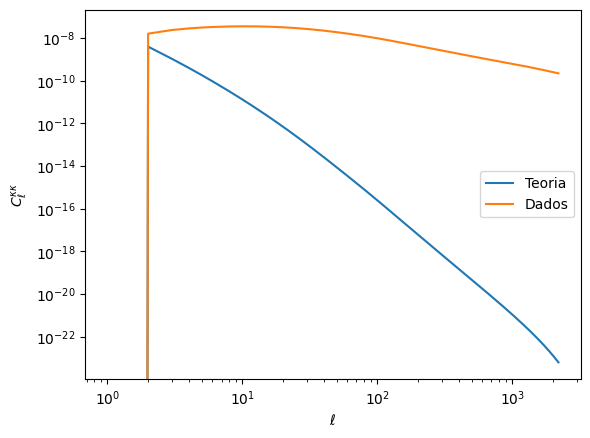

In [24]:
ell, cl_kk, _ = get_cl_kk(0.3, 0.820)
plt.loglog(ells, cl_kk, label="Teoria")
plt.loglog(ells, dv,        label="Dados")
plt.legend()
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell^{\\kappa\\kappa}$")